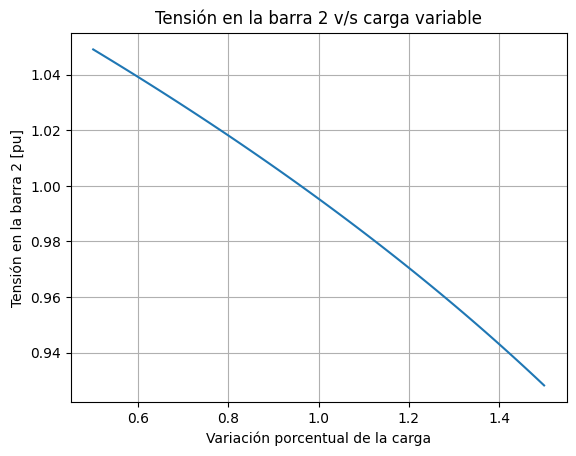

1.049076040189605
1.0480957831355706
1.0471121445353762
1.0461250992687579
1.04513462188418
1.0441406865927538
1.043143267262014
1.0421423374095435
1.0411378701964462
1.0401298384206634
1.039118214510126
1.0381029705157396
1.0370840781041986
1.0360615085506228
1.0350352327310102
1.0340052211145003
1.0329714437554496
1.031933870285297
1.0308924699042308
1.0298472113738177
1.0287980630032452
1.0277449926482936
1.026687967696424
1.0256269550588435
1.0245619211607853
1.0234928319315348
1.0224196527941913
1.0213423486551545
1.020260883893328
1.0191752223490331
1.0180853273126165
1.0169911615127514
1.015892687104412
1.0147898656565173
1.0136826581392289
1.0125710249108912
1.0114549257046062
1.0103343196144228
1.0092091650811357
1.0080794198776686
1.0069450410940424
1.0058059851218977
1.0046622076385685
1.003513663590681
1.0023603071772687
1.0012020918323787
1.0000389702071564
0.9988708941513864
0.9976978146944656
0.9965196820257984
0.995336445474579
0.9941480534889451
0.992954453614478
0.991

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandapower as pp
import math

#Para la creación de este modelo se asume un sistema trifásico, con voltaje linea-linea de 220[kV],
#analizamos el circuito equivalente para 1 fase 

#definimos los parámetros
f=50                          #frecuencia del sep
L=500                           #largo de la linea en [km]
r=0.02                          #resistencia de la linea en [ohm/km]
x=0.115                         #reactancia de la linea en [ohm/km]
b=19.1                          #capacitancia de la linea en [nF/km]
Vg_LN=500                       #voltaje de la linea en [kV]
Imax = 1                        #corriente maxima en las lineas [kV]

#respecto a la carga

Sc=1200                         #potencia aparente de la carga [MVA]
FP= 0.9                           #factor de potencia en la  carga
P=Sc*0.9                          #potencia activa en [Mw]
Q= math.sqrt((Sc**2)-(P**2))      #potencia reactiva en [Mvar]

# Crear red eléctrica
net = pp.create_empty_network()

# Añadir barras
bus1 = pp.create_bus(net, vn_kv=Vg_LN, name="Barra 1", slack=True)  # Barra 1 es designada como slack
bus2 = pp.create_bus(net, vn_kv=Vg_LN, name="Barra 2")  # Barra 2 se conecta la carga

# Añadir líneas
pp.create_line_from_parameters(net, from_bus=bus1, to_bus=bus2, length_km=L, r_ohm_per_km=r, x_ohm_per_km=x, c_nf_per_km=b, max_i_ka=Imax)
pp.create_line_from_parameters(net, from_bus=bus1, to_bus=bus2, length_km=L, r_ohm_per_km=r, x_ohm_per_km=x, c_nf_per_km=b, max_i_ka=Imax)
# Linea creada con parámetros vistos en en clases

# Añadir carga
pp.create_load(net, bus=bus2, p_mw=P, q_mvar=Q)

# Se añade fuente de generación conectada en la barra 1, (1[pu], el voltaje nominal [kV] se define en la barra a la que está conectada)
pp.create_ext_grid(net, bus=bus1, vm_pu=1, va_degree=0.0)

# Se definen funcion lineal para variar carga y lista para almacenar tensión en barra 2
niveles_carga = np.linspace(0.5, 1.5, 101)
tensiones_barra_dos = []

# Se ejecuta el programa dentro del for para cada variación puntual de carga
for carga in niveles_carga:
    net.load.loc[0, 'p_mw'] = P * carga
    net.load.loc[0, 'q_mvar'] = Q * carga

    pp.runpp(net)
    tension_barra_dos = net.res_bus.loc[1, 'vm_pu']
    tensiones_barra_dos.append(tension_barra_dos)

# Grafico de Tension, nivel de carga
plt.plot(niveles_carga, tensiones_barra_dos)
plt.xlabel('Variación porcentual de la carga')
plt.ylabel('Tensión en la barra 2 [pu]')
plt.title('Tensión en la barra 2 v/s carga variable')
plt.grid(True)
plt.show()
# Para ver los valores puntuales de tensión
for tension in tensiones_barra_dos:
    print(tension)

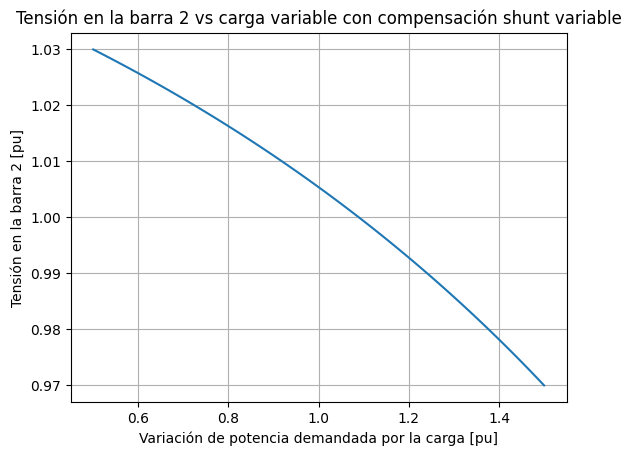

1.0300136571436747
1.0296014587121975
1.0291863360160558
1.028768270069277
1.028347241661465
1.0279232313542268
1.0274962194775208
1.0270661861259267
1.0266331111548426
1.0261969741765948
1.0257577545564682
1.0253154314086492
1.024869983592083
1.0244213897062386
1.023969628086786
1.023514676801172
1.0230565136441043
1.0225951161329343
1.0221304615029358
1.021662526702479
1.0211912883880978
1.0207167229194436
1.0202388063541257
1.0197575144424327
1.0192728226219376
1.018784706011974
1.0182931394079842
1.01779809727574
1.017299553745427
1.0167974826055857
1.0162918572969155
1.0157826509059285
1.0152698361584513
1.0147533854129744
1.0142332706538357
1.0137094634842418
1.0131819351191216
1.0126506563777997
1.012115597676491
1.011576729020612
1.011034019996895
1.0104874397653114
1.0099369570507828
1.0093825401346932
1.0088241568461724
1.0082617745531652
1.0076953601532663
1.0071248800643184
1.0065503002147644
1.005971586033747
1.005388702440947
1.0048016138361515
1.0042102840885425
1.003614

In [6]:
# Caso con compensación

import numpy as np
import matplotlib.pyplot as plt
import pandapower as pp
import math

# Parámetros del sistema
f = 50  # Frecuencia del sistema en Hz
L = 500  # Longitud de la línea en km
r = 0.02  # Resistencia de la línea en ohm/km
x = 0.115  # Reactancia de la línea en ohm/km
b = 19.1  # Capacitancia de la línea en nF/km
Vg_LN = 500  # Voltaje línea-neutro en kV
Imax = 1  # Corriente máxima en las líneas en kA

# Parámetros de la carga
Sc = 1200  # Potencia aparente de la carga en MVA
FP = 0.9  # Factor de potencia de la carga
P = Sc * FP  # Potencia activa en MW
Q = math.sqrt((Sc**2) - (P**2))  # Potencia reactiva en Mvar

# Crear red eléctrica
net = pp.create_empty_network()

# Añadir barras
bus1 = pp.create_bus(net, vn_kv=Vg_LN, name="Barra 1", slack=True)  # Barra 1 es la barra slack
bus2 = pp.create_bus(net, vn_kv=Vg_LN, name="Barra 2")  # Barra 2 es la barra a la que se conecta la carga

# Añadir líneas
linea1 = pp.create_line_from_parameters(net, from_bus=bus1, to_bus=bus2, length_km=L, r_ohm_per_km=r, x_ohm_per_km=x, c_nf_per_km=b, max_i_ka=Imax)
linea2 = pp.create_line_from_parameters(net, from_bus=bus1, to_bus=bus2, length_km=L, r_ohm_per_km=r, x_ohm_per_km=x, c_nf_per_km=b, max_i_ka=Imax)

# Añadir carga
load = pp.create_load(net, bus=bus2, p_mw=P, q_mvar=Q)

# Se añade fuente de generación conectada en la barra 1, (1[pu], el voltaje nominal [kV] se define en la barra a la que está conectada)
pp.create_ext_grid(net, bus=bus1, vm_pu=1, va_degree=0.0)

# Definir niveles de carga para simular
niveles_carga = np.linspace(0.5, 1.5, 101)

# Lista para almacenar las tensiones en la barra 2
tensiones_barra_dos = []

# Añadir una reactancia shunt variable
q_variacion = np.linspace(142.25, -288, len(niveles_carga))
reactancia_shunt1 = pp.create_shunt(net, bus=bus2, q_mvar=q_variacion[0], p_mw=0, name="Shunt 2", in_service=True)
reactancia_shunt2 = pp.create_shunt(net, bus=bus1, q_mvar=q_variacion[0], p_mw=0, name="Shunt 1", in_service=True)

# Iterar sobre cada nivel de carga
for idx, carga in enumerate(niveles_carga):
    # Actualizar la carga activa y reactiva en la barra 2
    net.load.loc[0, 'p_mw'] = P * carga
    net.load.loc[0, 'q_mvar'] = Q * carga
    
    # Actualizar la reactancia shunt según la variación lineal
    net.shunt.loc[0, 'q_mvar'] = q_variacion[idx]

    # Ejecutar la simulación de flujo de potencia
    pp.runpp(net)

    # Obtener la tensión en la barra 2 y almacenarla
    tension_barra_dos = net.res_bus.loc[1, 'vm_pu']
    tensiones_barra_dos.append(tension_barra_dos)

# Graficar la tensión en la barra 2 versus el nivel de carga
plt.plot(niveles_carga , tensiones_barra_dos)
plt.xlabel('Variación de potencia demandada por la carga [pu]')
plt.ylabel('Tensión en la barra 2 [pu]')
plt.title('Tensión en la barra 2 vs carga variable con compensación shunt variable')
plt.grid(True)
plt.show()

for tension in tensiones_barra_dos:
    print(tension)

In [2]:
import pandapower as pp
print(pp.__version__)

2.14.6
